In [1]:
import time
#time.sleep(60*60*2.5)

In [2]:
import numpy as np
import os
import pickle
import math

import os
import sys
import io
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


from collections import defaultdict

In [3]:
import math

def angle_to_sin_cos(angle):
    return(math.sin(angle), math.cos(angle))

def flatten_frame(frame, force_power, force_angle):
    result = list()
    for element in frame:
        result += element[0]
        for axis in range(3):
            result += angle_to_sin_cos(element[0][axis])
    result.append(force_power)
    result += angle_to_sin_cos(force_angle)
    return result


In [4]:
import pickle

def process_sample(sample, sample_name):
    force_power, force_angle = [float(x) for x in sample_name.split("_")]
    result = list()
    for n in range(240):
        if n == 4:
            frame_power = force_power
        else:
            frame_power = 0
        result.append(flatten_frame(sample[n], force_power, force_angle))
    return result

data_dir = os.path.join(os.getcwd(), "samplesGeneration", "data")
models_dir = os.path.join(os.getcwd(), "model")

data = list()
files = os.listdir(data_dir)
for num, fname in enumerate(files):
    if not num % 10:
        print(num, "/", len(files), end="\r")
    with open(os.path.join(data_dir, fname), "rb") as f:
        data.append(process_sample(pickle.load(f, encoding='latin1'), fname.rsplit(".", 1)[0]))

In [5]:
data = np.array(data)

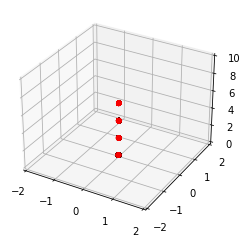

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=(-2,2),ylim=(-2,2), zlim=(0, 10))

xs = list()
ys = list()
zs = list()
sizes = list()
sample_to_plot = data[100]
for num, f in enumerate(sample_to_plot):
    for i in range(4):
        v = [f[9*i], f[9*i + 1], f[9*i + 2]]
        # print(v)
        xs.append(v[0])
        ys.append(v[2])
        zs.append(v[1])
        sizes.append([(len(sample_to_plot) - float(num))/len(sample_to_plot), 0, 0])
ax.scatter(xs, ys, zs, c=sizes)

plt.show()

In [9]:
import sqlite3
import numpy as np

def adapt_array(arr):
    """
    Save Numpy array to SqLite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    """ 
    Load Numpy array from Sqlite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

data_path = os.path.join(os.getcwd(), "samplesGeneration", "prepared_data.bd")

con = sqlite3.connect(data_path,isolation_level=None)
cur = con.cursor()
cur.execute('PRAGMA synchronous = 0')
cur.execute('PRAGMA journal_mode = OFF') 
cur.execute("create table if not exists data (id INTEGER PRIMARY KEY AUTOINCREMENT, x array, y array)")

sample_data = list()
frame_0 = list()
for num, sample in enumerate(data):
    print(num, "/", len(data), end="\r")
    for i in range(240-4):
        f0 = np.array(sample[i])
        f0[-3:] = 0
        f2 = np.array(sample[i+2])
        f2[-3:] = 0
        x = np.concatenate([np.array(sample[i]) - f0, np.array(sample[i+1]) - f0, np.array(sample[i+2]) - f0])
        y = np.array(sample[i+3][:-3]) - f2[:-3]
        sample_data.append((x, y))
        #if i == 15:
        #    print(x, y)
        #    dupa
cur.executemany("insert into data (x, y) values (?,?)", sample_data)
con.commit()

In [10]:
con.close()

In [ ]:
import os
# --- Uncomment to use only CPU (e.g. GPU memory is too small)
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# import sys
# sys.path.append("/usr/local/cuda-10.1/bin")
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-10.1/lib64"

import tensorflow as tf
tf.test.is_gpu_available(cuda_only=True) 